In [35]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

In [36]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [37]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [38]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path=None, num_class=None):
        super(TFGPT2Classifier, self).__init__()
        
        self.dir_path = 'gpt2' if dir_path is None else dir_path
        
        self.gpt2 = TFGPT2Model.from_pretrained(self.dir_path)
#         self.num_class = self.gpt2.config._num_labels if num_class is None else num_class
        self.num_class = self.gpt2.config.num_labels
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return outputs

In [39]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

I0502 01:29:45.291782 140214607935296 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /home/CompanyAI/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
I0502 01:29:45.293343 140214607935296 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt from cache at /home/CompanyAI/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


In [40]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 8
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = 174
DATA_IN_PATH = 'data_in/ENG'
DATA_OUT_PATH = "data_out/ENG"

In [41]:
# vocab = tokenizer.get_vocab()

tokenizer.pad_token = '#'
tokenizer.cls_token = '@'
tokenizer.sep_token = '$'

# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['#', '<|endoftext|>', '$', '@'] 
 [2, 50256, 3, 31]
[168, 243, 230, 167, 227, 243, 47991, 246, 168, 226, 116, 168, 248, 242, 11, 31619, 108, 246, 166, 108, 239, 168, 232, 113, 46695, 230, 46695, 97]
[15496, 995]
안녕하세요, 반갑습니다
Hello world


# Bag of Words Meets Bags of Popcorn (Eng)

In [8]:
import re
import json
import numpy as np
from bs4 import BeautifulSoup
import html5lib
from nltk.corpus import stopwords

In [9]:
TRAIN_BOW_DF = os.path.join(DATA_IN_PATH, 'popcorn', 'labeledTrainData.tsv')

train_data_bow = pd.read_csv(TRAIN_BOW_DF, header = 0, delimiter = '\t', quoting = 3)
train_data_bow.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [10]:
# 4장의 기존 전처리를 follow up한다. 다만, Bert가 사전학습을 할 때 일반적으로 특수문자나 불용어를 제거하지 않기 때문에 제외한다.

stop_words = set(stopwords.words('english')) # 영어 불용어들의 set을 만든다.

def preprocessing( review, remove_stopwords = False ): 
    # 불용어 제거는 옵션으로 선택 가능하다.
    
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()	

#     # 2. 영어가 아닌 특수문자들을 공백(" ")으로 바꾸기
#     review_text = re.sub("[^a-zA-Z]", " ", review_text)

    # 3. 대문자들을 소문자로 바꾸고 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = review_text.lower().split()

    if remove_stopwords: 
        # 4. 불용어들을 제거
    
        #영어에 관련된 불용어 불러오기
        stops = set(stopwords.words("english"))
        # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성
        words = [w for w in words if not w in stops]
        # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.	
        clean_review = ' '.join(words)

    else: # 불용어 제거하지 않을 때
        clean_review = ' '.join(words)

    return clean_review

In [11]:
def class_tokenizer(sent1, MAX_LEN):
    
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
        text = sent1,     
        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids'] + [tokenizer.cls_token_id]
    
    return input_id

In [12]:
train_data_bow_sents = []
train_data_bow_labels = []

for train_sent, train_label in zip(train_data_bow["review"][:50], train_data_bow["sentiment"][:50]):
    try:
        token_sent = class_tokenizer(preprocessing(train_sent, remove_stopwords = False), MAX_LEN)
        
    except Exception as e:
        print("Error message: {}".format(e))
        print("sentence: {}".format(train_sent))
        continue
        
    train_data_bow_sents.append(token_sent) #append는 빼 놓고 한다.
    train_data_bow_labels.append(train_label)

train_data_bow_sents = np.asarray(train_data_bow_sents, dtype=np.int32)
train_data_bow_labels = np.asarray(train_data_bow_labels, dtype=np.int32) 

print("num sents, attention_masks, labels {}, {}".format(len(train_data_bow_sents), len(train_data_bow_labels)))

num sents, attention_masks, labels 50, 50


In [14]:
cls_model = TFGPT2Classifier("gpt2")

In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [46]:
model_name = "tf2_gpt2_bag_of_words"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=999)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_bow_sents, train_data_bow_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/ENGtf2_gpt2_bag_of_words -- Folder already exists 

Train on 45 samples, validate on 5 samples
Epoch 1/20
40/45 [=========================>....] - ETA: 3s - loss: 2.0890 - accuracy: 0.4750 
Epoch 00001: val_accuracy improved from -inf to 0.40000, saving model to data_out/ENGtf2_gpt2_bag_of_words/weights.h5
45/45 [==============================] - 37s 817ms/sample - loss: 1.9735 - accuracy: 0.4889 - val_loss: 1.3465 - val_accuracy: 0.4000
Epoch 2/20
40/45 [=========================>....] - ETA: 2s - loss: 0.7757 - accuracy: 0.6250
Epoch 00002: val_accuracy improved from 0.40000 to 0.60000, saving model to data_out/ENGtf2_gpt2_bag_of_words/weights.h5
45/45 [==============================] - 24s 543ms/sample - loss: 0.8008 - accuracy: 0.5778 - val_loss: 0.5791 - val_accuracy: 0.6000
Epoch 3/20
40/45 [=========================>....] - ETA: 2s - loss: 0.6678 - accuracy: 0.6250
Epoch 00003: val_accuracy did not improve from 0.60000
45/45 [==============================] - 25s 551ms/

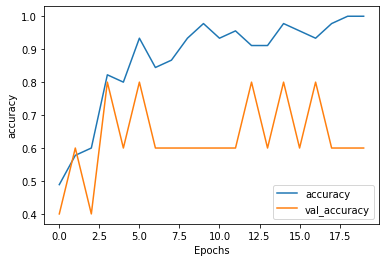

In [47]:
plot_graphs(history, 'accuracy')

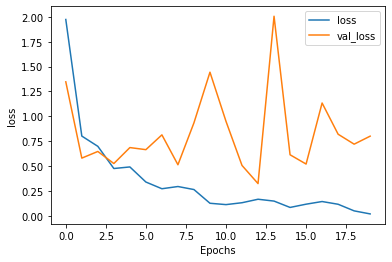

In [48]:
plot_graphs(history, 'loss')

# Bag of Words Test Dataset (제출 확인 필요)

In [49]:
#필요시 사용하세요.
cls_model.load_weights('data_out/movie_review_weights.h5')

In [50]:
TEST_BOW_DF = os.path.join(DATA_IN_PATH, 'popcorn', 'testData.tsv')

test_data_bow = pd.read_csv(TEST_BOW_DF, header=0, delimiter="\t", quoting=3)
test_data_bow.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [52]:
test_data_bow_sents = []
test_data_bow_idx = []

for test_sent, test_idx in zip(test_data_bow["review"], test_data_bow["id"]):
    try:
        token_sent = class_tokenizer(preprocessing(test_sent, remove_stopwords = False), MAX_LEN)
        
    except Exception as e:
        print("Error message: {}".format(e))
        print("sentence: {}".format(test_sent))
        continue
        
    test_data_bow_sents.append(token_sent)
    test_data_bow_idx.append(test_idx)

test_data_bow_sents = np.asarray(test_data_bow_sents, dtype=np.int32)

In [53]:
print("num sents, labels {}, {}".format(len(test_data_bow_sents), len(test_data_bow_idx)))

num sents, labels 25000, 25000


In [57]:
predictions = cls_model.predict(test_data_bow_sents, batch_size=512)
predictions = np.argmax(predictions, axis=1)

In [58]:
output = pd.DataFrame(data={"id": list(test_data_bow_idx), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_gpt2.csv', index=False, quoting=3)

# Quora Simliarity (ENG)

In [42]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = 31 * 2

In [43]:
TRAIN_QUORA_DF = os.path.join(DATA_IN_PATH, 'quora', 'train.csv')

train_data_quora = pd.read_csv(TRAIN_QUORA_DF, header = 0)
train_data_quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [44]:
# Simliarty tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def sim_tokenizer(sent1, sent2, MAX_LEN):
    
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
        text = sent1,                      # Sentence to encode.
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids'][1:] + [tokenizer.cls_token_id]
    
    return input_id

In [49]:
FILTERS = "([~.,!?\"':;)(])"

change_filter = re.compile(FILTERS)

train_input_ids = []
train_labels = []

for sent1, sent2, label in zip(train_data_quora['question1'], train_data_quora['question2'], 
                        train_data_quora['is_duplicate']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id = sim_tokenizer(sent1, sent2, MAX_LEN)
    
    train_input_ids.append(input_id)
    train_labels.append(label)
    
train_quora_input_ids = np.array(train_input_ids, dtype=int)
train_quora_labels = np.array(train_labels, dtype=int)

print("# sents: {}, # labels: {}".format(len(train_input_ids), len(train_labels)))

# sents: 404290, # labels: 404290


In [50]:
sim_model = TFGPT2Classifier("gpt2")

I0502 01:32:53.228691 140214607935296 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /home/CompanyAI/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.4c1d7fc2ac6ddabeaf0c8bec2ffc7dc112f668f5871a06efcff113d2797ec7d5
I0502 01:32:53.231693 140214607935296 configuration_utils.py:290] Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head"

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
sim_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [52]:
model_name = "tf2_gpt_quora"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=3)

checkpoint_path = os.path.join(DATA_OUT_PATH,model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = sim_model.fit(train_quora_input_ids, train_quora_labels, epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE, validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/ENG/tf2_gpt_quora -- Folder already exists 

Train on 363861 samples, validate on 40429 samples
Epoch 1/20
363776/363861 [============================>.] - ETA: 0s - loss: 0.3572 - accuracy: 0.8337
Epoch 00001: val_accuracy improved from -inf to 0.85644, saving model to data_out/ENG/tf2_gpt_quora/weights.h5
363861/363861 [==============================] - 1569s 4ms/sample - loss: 0.3572 - accuracy: 0.8337 - val_loss: 0.3124 - val_accuracy: 0.8564
Epoch 2/20
363776/363861 [============================>.] - ETA: 0s - loss: 0.2574 - accuracy: 0.8894
Epoch 00002: val_accuracy improved from 0.85644 to 0.88526, saving model to data_out/ENG/tf2_gpt_quora/weights.h5
363861/363861 [==============================] - 1553s 4ms/sample - loss: 0.2574 - accuracy: 0.8894 - val_loss: 0.2662 - val_accuracy: 0.8853
Epoch 3/20
363776/363861 [============================>.] - ETA: 0s - loss: 0.1983 - accuracy: 0.9177
Epoch 00003: val_accuracy improved from 0.88526 to 0.89292, saving model to data

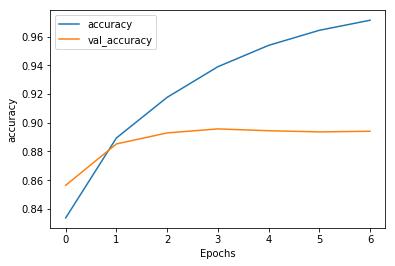

In [53]:
plot_graphs(history, 'accuracy')

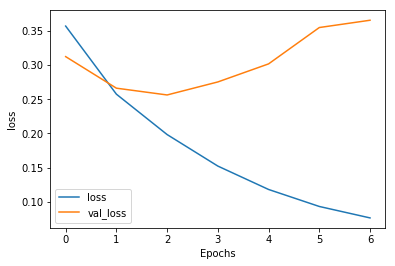

In [54]:
plot_graphs(history, 'loss')

# Quora Simliarity TEST

In [48]:
sim_model.load_weights(checkpoint_path)

ValueError: You are trying to load a weight file containing 2 layers into a model with 1 layers.

In [55]:
TEST_QUORA_DF = os.path.join(DATA_IN_PATH, 'quora', 'test.csv')

test_data_quora = pd.read_csv(TEST_QUORA_DF, encoding="utf-8")
valid_ids = [type(x) ==int for x in test_data_quora.test_id]
test_data = test_data_quora[valid_ids].drop_duplicates()

test_data_quora.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [56]:
test_input_sents = []
test_ids = []

for sent1, sent2, i in zip(test_data_quora['question1'], test_data_quora['question2'], 
                        test_data_quora['test_id']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id = sim_tokenizer(sent1, sent2, MAX_LEN)
    
    test_input_sents.append(input_id)
    test_ids.append(i)
    
test_input_sents = np.array(test_input_sents, dtype=int)

print("# sents: {}, # labels: {}".format(len(test_input_sents), len(test_ids)))

# sents: 2345796, # labels: 2345796


In [57]:
# 테스트 값 예측하기

predictions = sim_model.predict(test_input_sents, batch_size=512)

In [58]:
predictions = np.argmax(predictions, axis=1)

output = pd.DataFrame( data={"test_id":test_ids, "is_duplicate": list(predictions)} )
output.to_csv(os.path.join(DATA_OUT_PATH, "gpt2_quora_predict.csv"), index=False, quoting=3)